In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.svm import OneClassSVM
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, minmax_scale
from operator import itemgetter

In [2]:
satellite = pd.read_csv('../input/satelliteX.csv', header=None).astype('float64')
y_satellite = pd.read_csv('../input/satelliteY.csv', header=None)

satellite.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,92.0,115.0,120.0,94.0,84.0,102.0,106.0,79.0,84.0,102.0,102.0,83.0,101.0,126.0,133.0,103.0,92.0,112.0,118.0,85.0,84.0,103.0,104.0,81.0,102.0,126.0,134.0,104.0,88.0,121.0,128.0,100.0,84.0,107.0,113.0,87.0
1,84.0,102.0,106.0,79.0,84.0,102.0,102.0,83.0,80.0,102.0,102.0,79.0,92.0,112.0,118.0,85.0,84.0,103.0,104.0,81.0,84.0,99.0,104.0,78.0,88.0,121.0,128.0,100.0,84.0,107.0,113.0,87.0,84.0,99.0,104.0,79.0
2,84.0,102.0,102.0,83.0,80.0,102.0,102.0,79.0,84.0,94.0,102.0,79.0,84.0,103.0,104.0,81.0,84.0,99.0,104.0,78.0,84.0,99.0,104.0,81.0,84.0,107.0,113.0,87.0,84.0,99.0,104.0,79.0,84.0,99.0,104.0,79.0
3,80.0,102.0,102.0,79.0,84.0,94.0,102.0,79.0,80.0,94.0,98.0,76.0,84.0,99.0,104.0,78.0,84.0,99.0,104.0,81.0,76.0,99.0,104.0,81.0,84.0,99.0,104.0,79.0,84.0,99.0,104.0,79.0,84.0,103.0,104.0,79.0
4,84.0,94.0,102.0,79.0,80.0,94.0,98.0,76.0,80.0,102.0,102.0,79.0,84.0,99.0,104.0,81.0,76.0,99.0,104.0,81.0,76.0,99.0,108.0,85.0,84.0,99.0,104.0,79.0,84.0,103.0,104.0,79.0,79.0,107.0,109.0,87.0


In [3]:
satellite = scale(satellite)

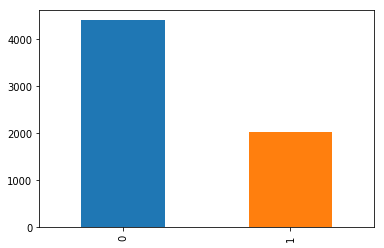

In [4]:
y_satellite.iloc[:, 0].value_counts().plot.bar()
plt.savefig('img.png')
plt.show()

In [5]:
y_satellite[0].value_counts()

0    4399
1    2036
Name: 0, dtype: int64

In [6]:
gamma_values, err_values_gamma = [], []
for g in np.linspace(0.0000015, 0.00015, 10):
    onesvm = OneClassSVM(nu=y_satellite.mean(), gamma=g)
    onesvm.fit(satellite)
    yhat = onesvm.predict(satellite)
    yhat = ((yhat - 1) * -1) / 2
    acc = accuracy_score(y_satellite, yhat)
    err = 1 - acc
    gamma_values.append(g)
    err_values_gamma.append(err)

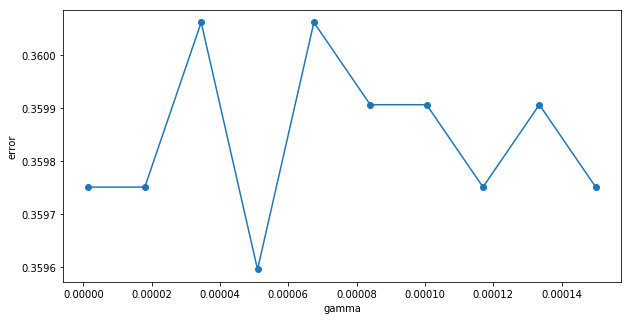

In [7]:
plt.subplots(figsize=(10, 5))
plt.plot(gamma_values, err_values_gamma, 'o-')
plt.xlabel('gamma')
plt.ylabel('error')
plt.show()

In [8]:
max(err_values_gamma), min(err_values_gamma)

(0.3600621600621601, 0.3595959595959596)

In [9]:
## Unsupervised (OneClassSVM)

In [10]:
onesvm = OneClassSVM(nu=y_satellite.mean(), gamma= 0.00005)
onesvm.fit(satellite)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=5e-05, kernel='rbf',
      max_iter=-1,
      nu=0    0.316395
dtype: float64, random_state=None, shrinking=True,
      tol=0.001, verbose=False)

In [11]:
yhat_satellite = onesvm.predict(satellite)
yhat_satellite = ((yhat_satellite - 1) * -1) / 2

In [12]:
print(accuracy_score(y_satellite, yhat_satellite))
print(confusion_matrix(y_satellite, yhat_satellite))
print(classification_report(y_satellite, yhat_satellite))

0.6404040404040404
[[3243 1156]
 [1158  878]]
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      4399
           1       0.43      0.43      0.43      2036

   micro avg       0.64      0.64      0.64      6435
   macro avg       0.58      0.58      0.58      6435
weighted avg       0.64      0.64      0.64      6435



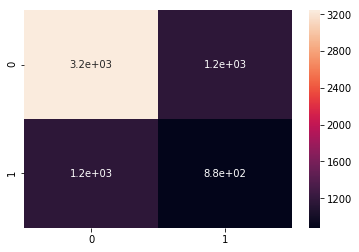

In [13]:
sns.heatmap(confusion_matrix(y_satellite, yhat_satellite), annot=True)
plt.savefig('heatmap_satellite.png')

In [14]:
tsne = TSNE(n_components=2)
satellite2 = tsne.fit_transform(satellite)

In [15]:
satellite2 = pd.DataFrame(satellite2, columns=['x','y'])
satellite2['ytrue'] = y_satellite[0]
satellite2['yhat']  = yhat_satellite
y_satellite.shape, satellite2.shape

((6435, 1), (6435, 4))

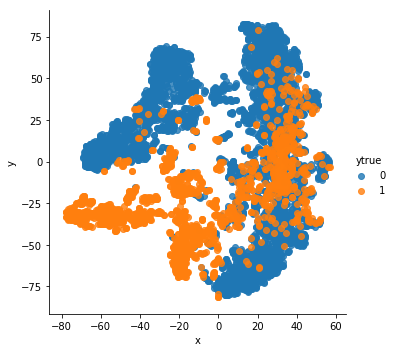

In [16]:
sns.lmplot(data=satellite2, x='x', y='y', hue='ytrue', fit_reg=False)

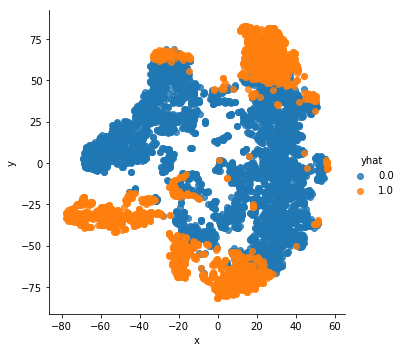

In [17]:
sns.lmplot(data=satellite2, x='x', y='y', hue='yhat', fit_reg=False)

In [18]:
## Supervised (SVC)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(satellite, y_satellite, test_size=0.3, shuffle=False, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=False, random_state=13)
svm = SVC(gamma = 'auto')
svm.fit(X_train, y_train.values.ravel())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [20]:
gamma_values, err_gamma = [], []
for g in np.linspace(0.000005, 0.0005, 10):
    svm = SVC(gamma=g, C=1.0)
    svm.fit(X_train, y_train.values.ravel())
    yhat = svm.predict(X_val)
    acc = accuracy_score(y_val, yhat)
    err = 1 - acc
    gamma_values.append(g)
    err_gamma.append(err)

In [21]:
gamma_c_values, err_gamma_c = [], []
for g in np.linspace(10e-5, 0.01, 5):
    for c in np.linspace(0.4, 10, 10):
        svm = SVC(gamma=g, C=c)
        svm.fit(X_train, y_train.values.ravel())
        yhat = svm.predict(X_val)
        acc = accuracy_score(y_val, yhat)
        err = 1 - acc
        gamma_c_values.append((g,c))
        err_gamma_c.append(err)

In [22]:
gamma_v = list(map(itemgetter(0), gamma_c_values))
c_v = list(map(itemgetter(1), gamma_c_values))

Text(0.5, 0, 'err')

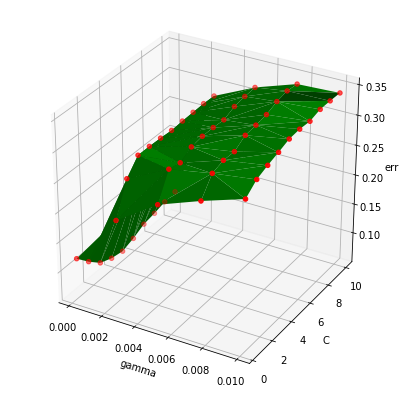

In [23]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(gamma_v, c_v, err_gamma_c, shade=True, color='green')
ax.scatter(gamma_v, c_v, err_gamma_c, color='red')
ax.set_xlabel('gamma')
ax.set_ylabel('C')
ax.set_zlabel('err')

In [24]:
max(err_gamma_c), min(err_gamma_c)

(0.34097633136094674, 0.06878698224852076)

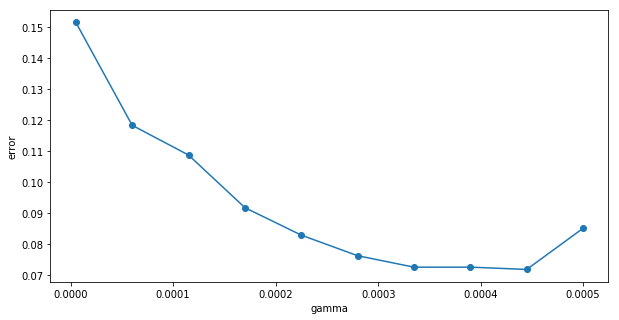

In [25]:
plt.subplots(figsize=(10, 5))
plt.plot(gamma_values, err_gamma, 'o-')
plt.xlabel('gamma')
plt.ylabel('error')
plt.show()

In [26]:
max(err_gamma), min(err_gamma)

(0.15162721893491127, 0.07174556213017746)

In [27]:
best_gamma_c = min(zip(gamma_c_values, err_gamma_c), key=lambda p: p[1])[0]
svm = SVC(gamma=best_gamma_c[0], C=best_gamma_c[1])
svm.fit(X_train, y_train.values.ravel())

SVC(C=4.666666666666667, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [28]:
yhat_satellite = svm.predict(X_test)

In [29]:
print(accuracy_score(y_test, yhat_satellite))
print(confusion_matrix(y_test, yhat_satellite))
print(classification_report(y_test, yhat_satellite))

0.845675815639565
[[1282    8]
 [ 290  351]]
              precision    recall  f1-score   support

           0       0.82      0.99      0.90      1290
           1       0.98      0.55      0.70       641

   micro avg       0.85      0.85      0.85      1931
   macro avg       0.90      0.77      0.80      1931
weighted avg       0.87      0.85      0.83      1931



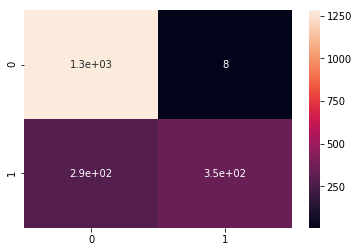

In [30]:
sns.heatmap(confusion_matrix(y_test, yhat_satellite), annot=True)
plt.savefig('heatmap_satellite.png')

In [31]:
test_satellite2 = TSNE(n_components=2).fit_transform(X_test)
test_satellite2 = pd.DataFrame(test_satellite2, columns=['x','y'])
test_satellite2['ytrue'] = y_test.values
test_satellite2['yhat'] = yhat_satellite

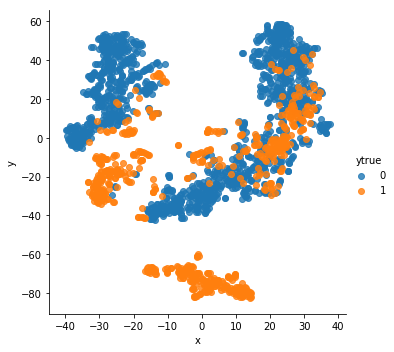

In [32]:
sns.lmplot(data=test_satellite2, x='x', y='y', hue='ytrue', fit_reg=False)

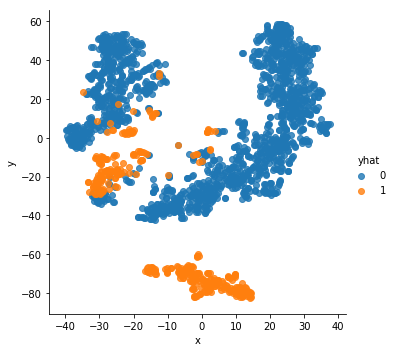

In [33]:
sns.lmplot(data=test_satellite2, x='x', y='y', hue='yhat', fit_reg=False)